# Open data

In [1]:
#!wget -r -N -c -np https://physionet.org/files/ludb/1.0.0/
#!pip3 install wfdb

In [1]:
import wfdb

record = wfdb.rdrecord('data/1')

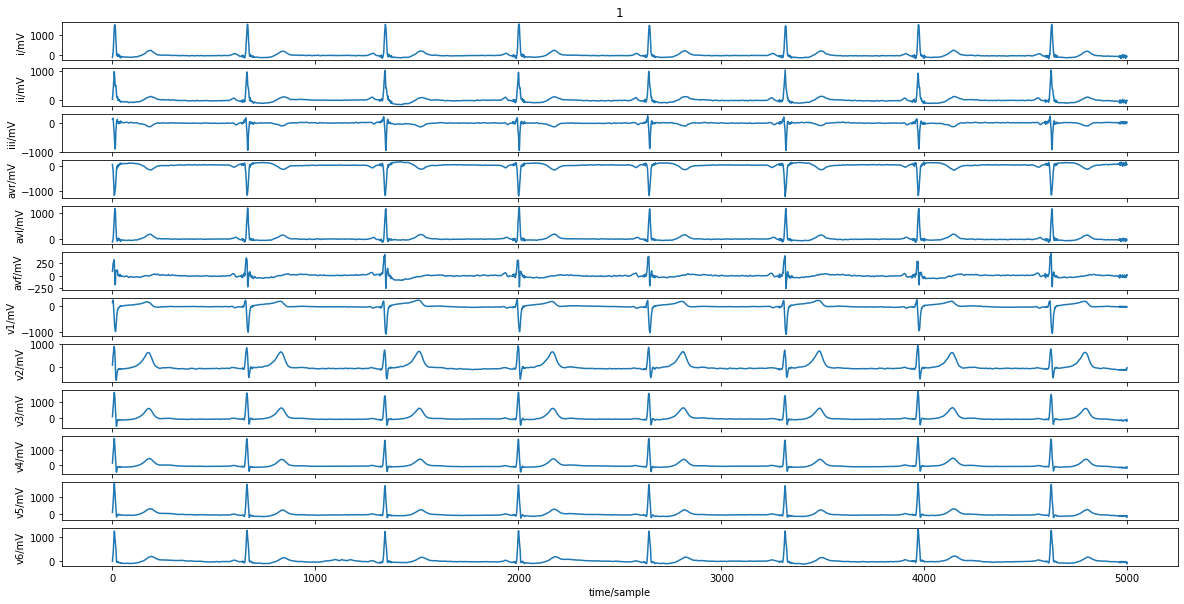

{'record_name': '1',
 'n_sig': 12,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 5000,
 'base_time': None,
 'base_date': None,
 'comments': ['<age>: 51',
  '<sex>: F',
  '<diagnoses>:',
  'Electric axis of the heart: left axis deviation.',
  'Left ventricular hypertrophy.',
  'Left ventricular overload.',
  'Non-specific repolarization abnormalities: posterior wall.'],
 'sig_name': ['i',
  'ii',
  'iii',
  'avr',
  'avl',
  'avf',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6'],
 'p_signal': array([[-120.00523697,   24.99079868,  145.00309435, ...,  144.99363598,
          105.00697831,  -24.98960619],
        [ -42.99554857,   97.00036805,  139.9958742 , ...,  309.99858577,
          235.01561813,   67.00949561],
        [  35.0091647 ,  194.99447921,  160.00600116, ...,  502.01527365,
          386.98774286,  152.0052825 ],
        ...,
        [ -63.99581042,  -41.99484726,   21.99801211, ..., -179.99575732,
         -167.0047693 , -100.00289026],
        [ -

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath

wfdb.plot_wfdb(record=record, title='1',figsize=(20,10),plot_sym=True) 
display(record.__dict__)

# Data Preprocessing

In [3]:
from easydict import EasyDict as ED
import pandas as pd
import numpy as np
from collections import namedtuple
import os,sys

In [32]:
def load_ann(db_dir, rec):
    ann_dict = ED()
    rec_fp = os.path.join(db_dir, rec)

    # wave delineation annotations
    _leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    _ann_ext = ['atr_i', 'atr_ii', 'atr_iii', 'atr_avr', 'atr_avl', 'atr_avf', 'atr_v1', 'atr_v2', 'atr_v3', 'atr_v4', 'atr_v5', 'atr_v6']
    ann_dict['waves'] = ED({l:[] for l in _leads})
    
    for l, e in zip(_leads, _ann_ext):
        ann = wfdb.rdann(rec_fp, extension=e)
        df_lead_ann = pd.DataFrame()
        symbols = np.array(ann.symbol)
        peak_inds = np.where(np.isin(symbols, ['p', 'N', 't']))[0]
        df_lead_ann['peak'] = ann.sample[peak_inds]
        df_lead_ann['onset'] = np.nan
        df_lead_ann['offset'] = np.nan
        for i, row in df_lead_ann.iterrows():
            peak_idx = peak_inds[i]
            if peak_idx == 0:
                df_lead_ann.loc[i, 'onset'] = row['peak']
                if symbols[peak_idx+1] == ')':
                    df_lead_ann.loc[i, 'offset'] = ann.sample[peak_idx+1]
                else:
                    df_lead_ann.loc[i, 'offset'] = row['peak']
            elif peak_idx == len(symbols) - 1:
                df_lead_ann.loc[i, 'offset'] = row['peak']
                if symbols[peak_idx-1] == '(':
                    df_lead_ann.loc[i, 'onset'] = ann.sample[peak_idx-1]
                else:
                    df_lead_ann.loc[i, 'onset'] = row['peak']
            else:
                if symbols[peak_idx-1] == '(':
                    df_lead_ann.loc[i, 'onset'] = ann.sample[peak_idx-1]
                else:
                    df_lead_ann.loc[i, 'onset'] = row['peak']
                if symbols[peak_idx+1] == ')':
                    df_lead_ann.loc[i, 'offset'] = ann.sample[peak_idx+1]
                else:
                    df_lead_ann.loc[i, 'offset'] = row['peak']

        df_lead_ann['duration'] = (df_lead_ann['offset'] - df_lead_ann['onset']) * 2.0

        df_lead_ann.index = symbols[peak_inds]

        for c in ['peak', 'onset', 'offset']:
            df_lead_ann[c] = df_lead_ann[c].values.astype(int)
            
        ECGWaveForm = namedtuple(
            typename='ECGWaveForm',
            field_names=['name', 'onset', 'offset', 'peak', 'duration'],
        )
        _symbol_to_wavename = ED(N='qrs', p='pwave', t='twave')
        
        for _, row in df_lead_ann.iterrows():
            w = ECGWaveForm(
                name=_symbol_to_wavename[row.name],
                onset=int(row.onset),
                offset=int(row.offset),
                peak=int(row.peak),
                duration=row.duration,
            )
            ann_dict['waves'][l].append(w)

    return ann_dict

In [33]:
def load_data(db_dir, rec):
    _leads = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
    rec_fp = os.path.join(db_dir, rec)
    wfdb_rec = wfdb.rdrecord(rec_fp, physical=True, channel_names=_leads)
    
    data = np.asarray(wfdb_rec.p_signal.T)

    return data

In [40]:
def data(num):
    a = load_ann('./data/',str(num))
    df = pd.DataFrame(a)
    df2 = df.waves['II']
    a = load_data('./data/',str(num))
    
    data2 = []
    for i in range(len(df2)):
        data2.append(list(df2[i]))        
        
    qrs_onset = []
    qrs_offset = []
    qrs_peak = []
    qrs_duration = []

    t_onset = []
    t_offset = []
    t_peak = []
    t_duration = []

    p_onset = []
    p_offset = []
    p_peak = []
    p_duration = []

    for i in range(len(data2)):
        if data2[i][0] =='qrs':
            qrs_onset.append(data2[i][1])
            qrs_offset.append(data2[i][2])
            qrs_peak.append(data2[i][3])
            qrs_duration.append(data2[i][4])

    qrs_onset_value = []
    qrs_offset_value = []
    qrs_peak_value = []


    for i in range(len(qrs_onset)):
        qrs_onset_value.append(a[1][qrs_onset[i]])
    for i in range(len(qrs_offset)):
        qrs_offset_value.append(a[1][qrs_offset[i]])
    for i in range(len(qrs_peak)):
        qrs_peak_value.append(a[1][qrs_peak[i]])  
        
    df_qrs = pd.DataFrame({'onset_value':qrs_onset_value,'offset_value':qrs_offset_value,\
                       'peak_value':qrs_peak_value,'duration':qrs_duration})
        
    import os
    if not os.path.exists('out_2'):
        os.makedirs('out_2')
    df_qrs.to_csv('./out_2/%s.csv'%num,index=False)

In [42]:
for i in range(1,201):
    data(i)

1
   onset_value  offset_value   peak_value  duration
0   -50.000000    -29.996319   877.990431      76.0
1     9.992639   -106.993007  1026.996688     100.0
2   -14.998160    -34.008097   924.990799      98.0
3   -17.997792    -56.993007   917.004049      88.0
4   -41.994847    -73.997056  1000.000000     122.0
5   -32.995951    -64.998160   858.005153      92.0
2
   onset_value  offset_value  peak_value  duration
0   -62.002479    -32.004437  529.998043      90.0
1   -52.998173     -5.007830  549.996738      82.0
2   -17.992301      5.007830  575.003262     100.0
3   -59.001044    -75.003262  579.994780      86.0
4   -29.003001      6.997912  542.003784      86.0
5  -111.999217    -32.999478  589.994128      96.0
6   -19.003654     15.007177  657.004437      96.0
7   -66.993997    -52.998173  601.999870      90.0
8   -94.006916    -38.007308  694.000391      82.0
3
   onset_value  offset_value   peak_value  duration
0   -29.986178    -51.991464  1522.991331     116.0
1   -73.013596  

    onset_value  offset_value   peak_value  duration
0    -81.987449    -81.987449  1447.994491     108.0
1   -107.012461   -151.995115  1401.998363     112.0
2   -110.000910   -147.005704  1395.007991     114.0
3    -97.995141   -101.997064  1403.011837     104.0
4    -99.996102   -139.001858  1408.001247     112.0
5   -107.999948   -143.991269  1329.989735     114.0
6   -103.010538    -99.996102  1405.012798      98.0
7   -110.000910   -114.990320  1449.995452     106.0
8   -107.999948   -137.000897  1374.998376     116.0
9   -110.000910   -159.011473  1364.993568     118.0
10   -99.996102   -139.989346  1360.004158     120.0
19
   onset_value  offset_value  peak_value  duration
0   -55.008065    -49.003795  929.990583     118.0
1   -52.005930    -49.003795  935.006573     148.0
2   -25.005361    -14.992028  924.993241      86.0
3   -36.995254      4.997343  894.990537      94.0
4   -41.992597    -52.005930  852.997940     130.0
5   -49.992075    -22.991506  892.995329      88.0
6   

    onset_value  offset_value  peak_value  duration
0      9.997858      7.998286  495.005039     118.0
1     -9.997858     16.996358  474.993454     114.0
2     25.994430    -39.007514  479.992383     124.0
3    -17.996144    -41.007086  404.992581     122.0
4    -74.999802    -94.995517  435.002023     104.0
5    -83.997873    -83.997873  495.005039     128.0
6    -26.994216    -52.004729  505.002896     138.0
7    -89.996588    -92.995945  324.993851     116.0
8    -83.997873   -135.002817  399.993652     116.0
9   -124.005173   -110.992089  505.002896     126.0
10  -109.992303   -151.999175  435.002023     116.0
11  -108.992517   -115.007102  479.992383     120.0
12   -62.002587    -70.000873  415.006308     118.0
13   -85.997445    -40.007300  399.993652     100.0
14   -61.002801    -21.995287  505.002896     136.0
15     0.000000    -73.000230  474.993454     130.0
16   -44.006443    -91.996160  394.994723     124.0
17   -70.000873    -88.996802  404.992581     122.0
18   -64.002

   onset_value  offset_value  peak_value  duration
0     9.993802    -37.015370  954.982624     190.0
1    19.987604    -94.993349  894.984992     162.0
2    19.987604    -34.995717  852.015127     162.0
3    41.994860    -90.013859  919.986907     152.0
4    62.017285    -62.017285  795.012153     160.0
5    44.989519    -32.001059  770.010238     152.0
6    15.008113    -79.985236  753.992297     176.0
7    30.016227     12.013455  764.995926     180.0
52
   onset_value  offset_value  peak_value  duration
0    37.004800    -54.006529  729.008692     112.0
1   -15.006718    -20.003072  729.008692     142.0
2    68.995592    -87.003653  773.993535     104.0
3   -18.008061    -21.998083  723.994682     162.0
4    76.993289    -96.996361  673.995830     118.0
5    67.000581      9.992709  662.008111     184.0
6     1.995011     53.000196  622.001967     126.0
7   107.995403    -82.007299  748.994109     108.0
8    92.000007    -79.005955  644.000049     132.0
53
   onset_value  offset_va

   onset_value  offset_value   peak_value  duration
0  -101.986226    -91.994237  1587.990365     100.0
1   -72.010258    -79.992527  1498.005848      96.0
2   -82.992955    -85.002675  1415.012893      96.0
3   -94.994664    -87.012395  1474.993136      98.0
4   -82.002247    -75.010685  1559.995811     102.0
5   -85.002675    -75.010685  1519.999547     102.0
6   -85.002675    -84.011968  1495.005421      98.0
7   -97.004385    -97.004385  1434.996872      92.0
8   -82.992955   -127.008659  1392.990888      86.0
69
    onset_value  offset_value  peak_value  duration
0    -47.002062    -37.005110  439.996985     100.0
1    -45.002671    -43.997513  428.000642      84.0
2    -39.004500    -47.002062  445.000923      78.0
3     -7.003329    -17.000281  450.004862      92.0
4    -24.997842    -51.995075  418.003691      88.0
5    -56.999013    -62.002952  456.997265      90.0
6    -22.998452    -43.997513  462.995436      80.0
7      9.996952    -17.000281  464.000594      92.0
8    -32.

   onset_value  offset_value  peak_value  duration
0  -105.006398   -144.996246  394.998890      84.0
1   -33.997540    -44.995189  489.994607     104.0
2   105.006398     74.991981  609.999401      98.0
3   114.999454     90.008001  609.999401      84.0
4   -35.002133    -29.996792  530.002080      96.0
5    35.002133      9.993056  550.005816      88.0
6   -44.995189    -50.000529  454.992474      90.0
7   -64.998925   -123.000948  409.997286     104.0
85
   onset_value  offset_value  peak_value  duration
0  -104.006083    -75.004269  525.005313      78.0
1   -63.998074    -39.995725  469.998907      80.0
2    14.003417     12.001174  509.994632      82.0
3   -44.000211     -7.996688  504.995166      78.0
4   -63.998074    -48.004697  545.003175      82.0
5  -105.001063    -95.002131  445.001578      70.0
6  -127.001168   -105.001063  410.005319      86.0
7  -105.996042    -95.002131  504.995166      80.0
8   -83.995937    -48.004697  484.997304      78.0
9   -44.000211     -9.998931

   onset_value  offset_value  peak_value  duration
0   -59.993779    -62.006324  764.999692      92.0
1    55.004000     48.999632  839.996075     100.0
2   -65.000191    -51.993500  824.993472      90.0
3  -139.996574   -139.996574  669.994295     106.0
4  -108.993412   -112.003912  665.004516     100.0
5   -35.992941    -55.004000  745.007310      94.0
6   -48.999632    -54.006044  824.993472      98.0
7   -55.004000     -5.006412  845.002487      78.0
99
    onset_value  offset_value   peak_value  duration
0    -40.009742     13.011864  1624.986953      90.0
1    -59.005671     -5.009915  1419.997913      86.0
2   -118.985492   -110.009394  1390.008002      82.0
3   -209.998956   -145.009220  1254.983822      82.0
4   -144.000278    -69.999652  1340.013221      84.0
5    -99.989563    -99.989563  1440.002783      76.0
6     18.995929     69.999652  1635.006784      84.0
7    -90.004523    -44.984866  1699.996521      82.0
8   -200.013916   -165.014090  1480.012525      84.0
9   -289

    onset_value  offset_value  peak_value  duration
0     15.003653   -100.002609  679.991650      88.0
1     40.009742    -59.992868  560.005914      82.0
2     40.009742    -41.009985  579.989041     102.0
3     -2.000487    -69.995303  730.003827      88.0
4     58.992624    -40.009742  609.996347      80.0
5     66.994573     20.004871  689.994086      92.0
6     56.992137     49.990432  725.002609      92.0
7    106.004071     54.991650  789.996695      92.0
8     90.000174    -38.009254  789.996695      94.0
9     99.002366    -59.992868  740.006262      84.0
10    20.004871    -59.992868  579.989041      84.0
11   -49.990432   -120.007480  689.994086      86.0
12   -42.010229   -144.991824  645.004871      84.0
13   -81.998226    -44.989215  609.996347      94.0
113
   onset_value  offset_value   peak_value  duration
0  -154.994302    -86.989625  1180.008454      86.0
1  -114.997367    -55.001965  1194.988765      80.0
2  -145.007428    -75.000433  1054.999493      78.0
3  -145.

   onset_value  offset_value  peak_value  duration
0   -26.980232    -64.987167  799.975600     130.0
1   -70.007836    -64.987167  799.975600     124.0
2    29.983249    -35.003918  849.994604     120.0
3     9.994416    -51.004368  799.975600     136.0
128
   onset_value  offset_value  peak_value  duration
0   -77.007230    -45.001167  784.994188      82.0
1   -90.002334    -30.999852  764.998426      86.0
2  -109.998095      5.009645  825.007118      84.0
3  -105.009859    -25.005406  804.989949      82.0
4   -74.994808    -25.005406  864.998641      86.0
5   -77.007230    -35.003286  845.002879      86.0
6   -77.007230      5.009645  804.989949      78.0
129
   onset_value  offset_value  peak_value  duration
0       -100.0         -77.0       545.0     110.0
1        -52.0          -6.0       565.0      94.0
2         -8.0         -62.0       545.0     120.0
3        -50.0         -92.0       545.0      98.0
4        -70.0         -62.0       520.0     100.0
5        -60.0         

   onset_value  offset_value  peak_value  duration
0  -177.996947   -214.010482  689.999680      66.0
1   106.994567    101.999210  979.004558      64.0
2    22.991450     11.997396  951.999744      70.0
3   -11.997396      3.010023  903.988814      68.0
4   -47.007589    -65.003682  859.991247      66.0
5  -173.001590   -182.992304  782.990169      72.0
6  -229.999893   -182.992304  780.001494      64.0
7   -72.005721    -69.999039  870.003309      66.0
8   -20.002775    -40.005550  861.997929      70.0
145
   onset_value  offset_value   peak_value  duration
0  -189.984322   -119.990098  2356.989957      76.0
1  -131.979400    -99.991748  2160.015921      78.0
2  -134.988860    -51.986001  2300.004369      78.0
3  -121.980225    -86.983113  2354.999830      78.0
4  -108.000796    -86.983113  2306.994083      82.0
5   -11.989302     -4.999587  2315.003131      78.0
6   -13.979429     23.007810  2434.022435      82.0
7  -149.016829   -103.001209  2300.004369      80.0
8  -136.978987   -

   onset_value  offset_value   peak_value  duration
0   116.993120    174.987650  1611.998924      76.0
1    -6.988261     84.983674  1485.005362      70.0
2  -199.004775   -152.014748  1234.994317      70.0
3  -253.987124   -190.008394  1192.984429      74.0
4  -272.983947   -280.012370  1160.011085      96.0
5  -183.020133   -152.014748  1232.986196      76.0
6  -113.980939    -56.990469  1238.006498      68.0
7    74.983232    126.993562  1561.996715      70.0
162
   onset_value  offset_value   peak_value  duration
0     0.000000     48.006428  1035.004261      96.0
1    -8.009601     12.001607   991.987840      98.0
2  -175.008509   -132.990089   788.011700     100.0
3  -240.006551   -200.009724   654.996021      98.0
4  -163.006902   -119.990481   852.011741      94.0
5   -92.993262    -64.998042   914.988190      94.0
6   -97.010858    -37.002823   932.005394     114.0
7   -82.987658    -27.995220   924.993794      98.0
8   -85.009251      1.996003   921.999790     106.0
9   -69.

    onset_value  offset_value  peak_value  duration
0    -24.007634    -49.003092  712.008933      92.0
1    -44.998880    -55.000591  627.003209      94.0
2   -128.999141    -62.991376  641.996955     108.0
3   -131.997890   -221.995650  550.005909      96.0
4   -159.992097   -239.000323  602.007751     102.0
5   -192.008157   -175.003484  511.992351      96.0
6   -131.997890   -131.997890  582.004329      94.0
7    -11.994997    -73.998550  753.991424      92.0
8    -94.001972    -18.997959  666.992413      98.0
9    -52.001842   -159.992097  682.003800     100.0
10   -92.008686    -84.000261  706.999257     100.0
11  -107.002433   -107.002433  657.008342      90.0
179
   onset_value  offset_value   peak_value  duration
0   103.998848    -20.004908  1092.001238     120.0
1  -148.009645   -205.010296   957.995028     120.0
2   -24.992798   -114.001302  1018.009752     112.0
3  -183.004897   -226.989021   843.006818     106.0
4  -252.995402   -332.001451   790.007148     128.0
5  -342.

   onset_value  offset_value  peak_value  duration
0   -37.996192    -58.004290  229.997157      88.0
1   -44.997656    -61.998598  285.003432      86.0
2   -73.003509    -36.999900  239.996636      92.0
3   -51.999119    -36.999900  286.996016      76.0
4     4.999740    -29.998437  382.000207      74.0
5   -34.998177   -108.997977  337.002551      74.0
6  -100.003930   -140.001846  229.997157      72.0
7  -110.003409   -113.997717  145.001586      76.0
193
   onset_value  offset_value   peak_value  duration
0     8.985524     26.990738  1616.984349     110.0
1   -77.009016    -55.006440  1495.013547      92.0
2  -185.006133   -174.995644  1359.991527     106.0
3  -192.010058   -164.985155  1414.997967      98.0
4  -132.015456   -133.006256  1502.017472     112.0
5  -158.015395   -137.994417  1440.007106     104.0
6  -122.995767    -85.003741  1540.009498      90.0
7   117.016806     59.994602  1753.987967     104.0
8  -197.989019   -170.007482  1325.006064     102.0
194
   onset_valu

# Determine normal & abnormal

In [7]:
define = []
for i in range(1,201):
    record = wfdb.rdrecord('data/%s'%i)
    define.append(record.__dict__)

In [8]:
columns = []
for key in define[0].keys():
    columns.append(key)

In [9]:
import pandas as pd
type(define[0])
define_df = pd.DataFrame(columns=columns)

In [11]:
for i in range(len(define)):
    define_df=define_df.append({ # 'record_name' : define[i]['record_name'],
#                     'n_sig':define[i]['n_sig'],
#                     'fs': define[i]['fs'],             
#                     'counter_freq':define[i]['counter_freq'],
#                     'base_counter': define[i]['base_counter'],
#                   'sig_len': define[i]['sig_len'],
#                     'base_time': define[i]['base_time'],
#                      'base_date': define[i]['base_date'],
                 'comments': define[i]['comments'],
#                  'sig_name': define[i]['sig_name'],
#                   'p_signal': define[i]['p_signal'],
#                  'd_signal': define[i]['d_signal'],
#                  'e_p_signal': define[i]['e_p_signal'],
#                  'e_d_signal': define[i]['e_d_signal'],
#                  'file_name': define[i]['file_name'],
#                  'fmt': define[i]['fmt'],
#                  'samps_per_frame': define[i]['samps_per_frame'],
#                  'skew': define[i]['skew'],
#                  'byte_offset': define[i]['byte_offset'],
#                   'adc_gain': define[i]['adc_gain'],
#                  'baseline': define[i]['baseline'],
#                  'units': define[i]['units'],
#                  'adc_res': define[i]['adc_res'],
#                  'adc_zero': define[i]['adc_zero'],
#                  'init_value': define[i]['init_value'],
#                  'checksum': define[i]['checksum'],
                 'block_size': define[i]['block_size']},ignore_index=True)

In [12]:
index = []
pa = []
for i in range(len(define_df)):
    if define_df.comments[i][3] == 'Electric axis of the heart: normal.':
        #print(df.comments[i][3])
        index.append(i)
    try:
        define_df.comments[i][4]
    except:
        print("")
    else:
        if define_df.comments[i][4] == 'Electric axis of the heart: normal.':
            index.append(i)            

In [43]:
print(index)

[1, 5, 15, 16, 17, 24, 29, 32, 35, 36, 38, 39, 40, 41, 46, 47, 48, 67, 68, 69, 70, 74, 77, 79, 85, 87, 93, 95, 97, 99, 101, 104, 112, 114, 118, 122, 127, 132, 134, 139, 141, 143, 144, 146, 148, 149, 151, 152, 155, 156, 158, 160, 161, 164, 165, 166, 168, 169, 170, 171, 173, 174, 177, 180, 181, 183, 184, 186, 190, 192, 194, 196, 197, 198, 199]


In [28]:
normal_index = index

In [23]:
import os
if not os.path.exists('normal'):
    os.makedirs('normal')
    
if not os.path.exists('abnormal'):
    os.makedirs('abnormal')

In [45]:
import shutil

for i in range(len(normal_index)):
    print(normal_index[i])
    shutil.move("./out_2/%s.csv"%normal_index[i], "./normal/%s.csv"%normal_index[i])

1
5
15
16
17
24
29
32
35
36
38
39
40
41
46
47
48
67
68
69
70
74
77
79
85
87
93
95
97
99
101
104
112
114
118
122
127
132
134
139
141
143
144
146
148
149
151
152
155
156
158
160
161
164
165
166
168
169
170
171
173
174
177
180
181
183
184
186
190
192
194
196
197
198
199


OSError: [Errno 66] Directory not empty: './out_2' -> './abnormal'

In [48]:
os.rename('./out_2','./abnormal')

## read normal

In [97]:
import pandas as pd
import glob

path = './normal' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
a = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    a.append(len(df))
    
    li.append(df)

normal = pd.concat(li, axis=0, ignore_index=True)

## read abnormal

In [98]:
import pandas as pd
import glob

path = './abnormal' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
a = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    a.append(len(df))
    
    li.append(df)

abnormal = pd.concat(li, axis=0, ignore_index=True)

## normal에서 비정상군 한 번 더 확인

In [99]:
normal.head(1)

,onset_value,offset_value,peak_value,duration
0,-6.993983,-30.003441,547.000121,102.0


In [100]:
def mark(df):
    a = []
    for i in range(len(df)):
        if normal.duration[i] >= 120.0:
            normal.label[i] = 1
        elif normal.duration[i] < 60.0:
            normal.label[i] = 1
    return df

In [101]:
import numpy as np

normal['label'] = 0
new_normal= mark(normal)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [102]:
abnormal['label'] = 1
new_abnormal= abnormal

In [103]:
df = pd.concat([new_normal, new_abnormal])

In [58]:
df.to_csv('data_2.csv',index=False)

In [93]:
df.head(2)

,onset_value,offset_value,peak_value,duration,label
0,-6.993983,-30.003441,547.000121,102.0,0
1,63.001646,-64.991955,646.999191,84.0,0


# EDA

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [125]:
equilibre=df['label'].value_counts()

In [126]:
print(equilibre)

1    1168
0     605
Name: label, dtype: int64


In [107]:
df.describe()

,onset_value,offset_value,peak_value,duration,label
count,1831.000000,1831.000000,1831.000000,1831.000000,1831.000000
mean,-68.400238,-72.018131,823.122340,97.449481,0.669579
std,94.282314,92.309641,472.613133,21.503756,0.470493
min,-804.987391,-619.995020,-1210.005602,0.000000,0.000000
25%,-114.002526,-118.003801,476.496244,84.000000,0.000000
50%,-65.008111,-69.995303,789.992784,92.000000,1.000000
75%,-21.988165,-29.996556,1158.999601,106.000000,1.000000
max,499.988784,499.988784,2434.022435,250.000000,1.000000


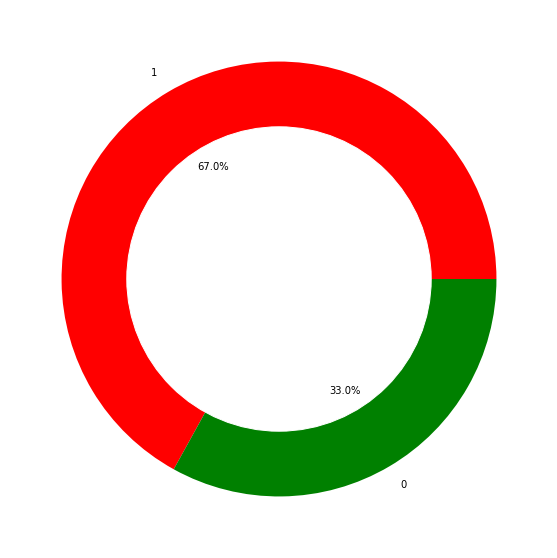

In [64]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['1','0'], colors=['red','green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

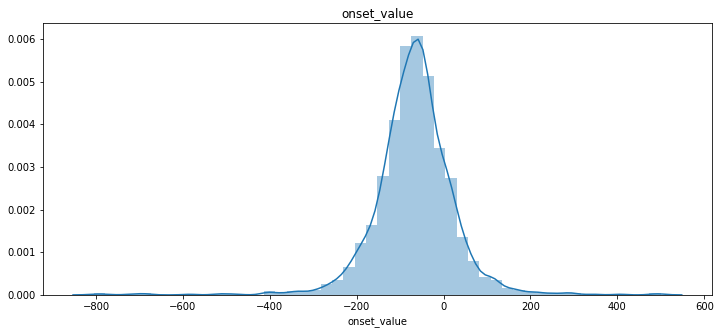

In [67]:
plt.figure(figsize=(12,5))
plt.title("onset_value")
ax = sns.distplot(df["onset_value"])

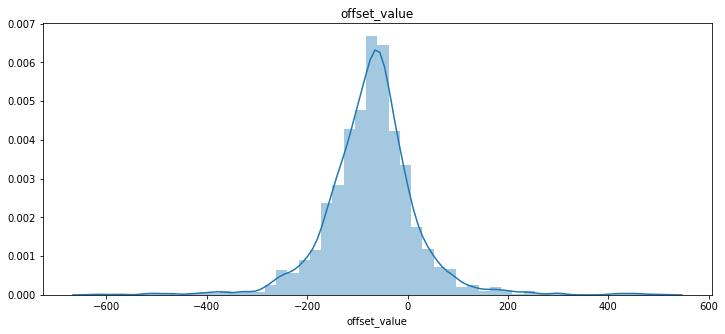

In [66]:
plt.figure(figsize=(12,5))
plt.title("offset_value")
ax = sns.distplot(df["offset_value"])

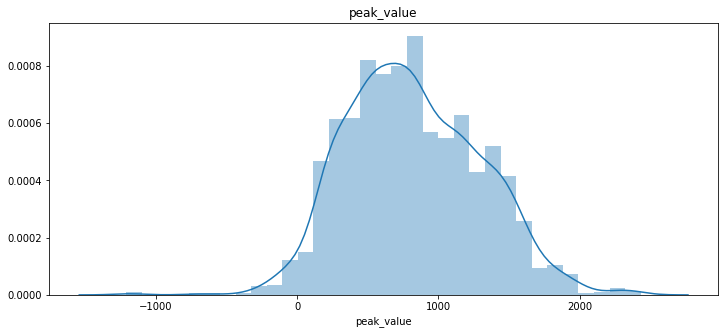

In [68]:
plt.figure(figsize=(12,5))
plt.title("peak_value")
ax = sns.distplot(df["peak_value"])

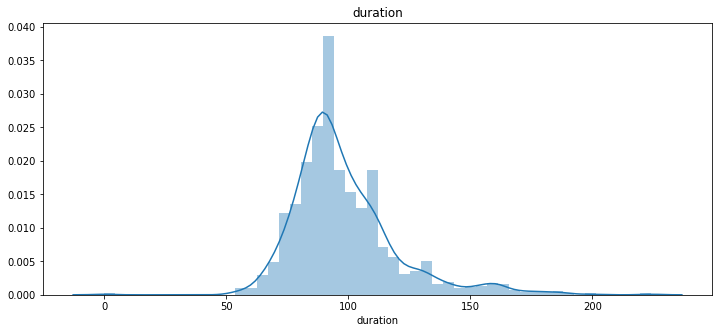

In [69]:
plt.figure(figsize=(12,5))
plt.title("duration")
ax = sns.distplot(new_abnormal["duration"])

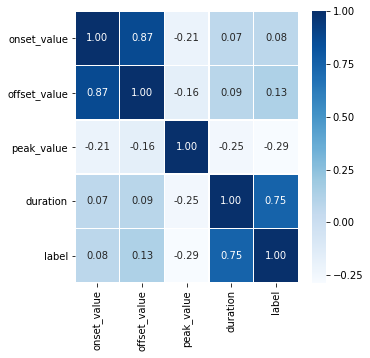

In [108]:
jan_corr = new_normal.corr()

import matplotlib.pyplot as plt 
import seaborn as sns  

plt.figure(figsize=(5,5))
sns.heatmap(jan_corr, annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

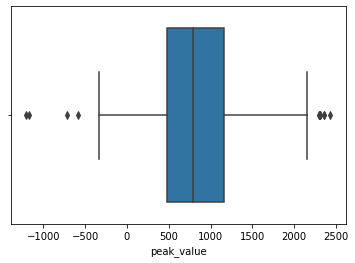

In [71]:
import seaborn as sns

ax = sns.boxplot(x=df["peak_value"])

## Remove Outlier 
## 1) peak value

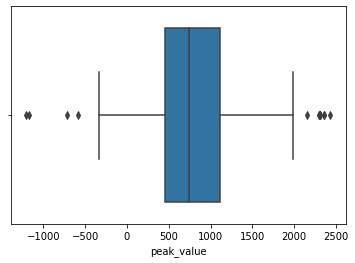

In [72]:
ax = sns.boxplot(x=new_abnormal["peak_value"])

In [109]:
def removeOutlier(df, column):
    abnormal = df[df['label'] == 1][column]
    q1 = np.percentile(abnormal.values, 25)
    q3 = np.percentile(abnormal.values, 75)
    
    iqt = 1.5 * (q3-q1)
    
    low = q1 - iqt
    high = q3 + iqt
    
    index = abnormal[(abnormal < low) | (abnormal > high)].index
    print(len(index))
    
    df.drop(index, axis = 0, inplace=True)
    
    print(df.shape)
    
    return df

In [74]:
ddf = removeOutlier(new_abnormal, 'peak_value')

13
(1136, 5)


## 2) onset

In [75]:
new_abnormal.head(1)

,onset_value,offset_value,peak_value,duration,label
0,-39.005828,-261.002309,1179.996464,172.0,1


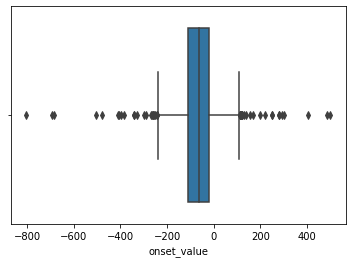

In [76]:
ax = sns.boxplot(x=new_abnormal["onset_value"])

In [77]:
new_abnormal = removeOutlier(new_abnormal, 'onset_value')

47
(1089, 5)


## 3) off set

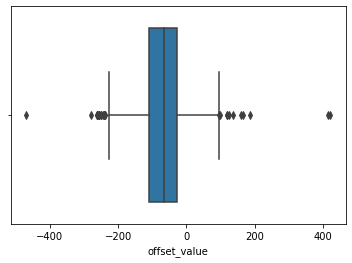

In [78]:
ax = sns.boxplot(x=new_abnormal["offset_value"])

In [79]:
new_abnormal = removeOutlier(new_abnormal, 'offset_value')

30
(1059, 5)


## 4) duration

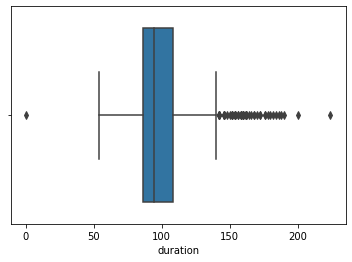

In [110]:
ax = sns.boxplot(x=new_abnormal["duration"])

In [111]:
new_abnormal = removeOutlier(new_abnormal, 'duration')

58
(1091, 5)


In [112]:
df = pd.concat([new_normal, new_abnormal])

In [127]:
len(df)

1773

# Training

In [113]:
x = df.drop(columns=['label'])
y = df['label']

In [114]:
#claim
from sklearn import model_selection
from sklearn import svm


X_train, X_test, Y_train, Y_test = model_selection.train_test_split (x, y, test_size=0.3, random_state=42)

## Normalization

In [115]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [116]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *

from collections import Counter
import matplotlib.pyplot as plt


X_train, Y_train = SMOTE().fit_sample(X_train, Y_train)

## SVM

In [117]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


svm = SVC()
parameter_candidates = [
  {'kernel':['linear']},
  {'kernel':['rbf'], 'gamma':[0.001, 0.0001]}
]
clf = GridSearchCV(svm, parameter_candidates,n_jobs=-1)
clf.fit(X_train,Y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'kernel': ['linear']},
                         {'gamma': [0.001, 0.0001], 'kernel': ['rbf']}])

In [118]:
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Best C: 1.0
Best Kernel: linear
Best Gamma: scale


In [119]:
from sklearn.svm import SVC, LinearSVC

svm = SVC(C=1.0, kernel='linear', gamma='scale')

svm.fit(X_train, Y_train)
y_predict = svm.predict(X_test)


from sklearn.metrics import classification_report
print(classification_report(Y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.4200    0.7159    0.5294       176
           1     0.7845    0.5112    0.6190       356

    accuracy                         0.5789       532
   macro avg     0.6022    0.6136    0.5742       532
weighted avg     0.6639    0.5789    0.5894       532



In [121]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

grid = {'criterion': ["gini", "entropy"],
        'max_depth': range(1, 10),
        'min_samples_leaf': range(2, 10),
        }

search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=8, 
                             cv=5, verbose=1, return_train_score=True)

search.fit(X_train,Y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed:    8.9s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(2, 10)},
             return_train_score=True, verbose=1)

In [122]:
print(search.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5}


In [123]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=9, min_samples_leaf=5)
dt.fit(X_train, Y_train)


y_predict = dt.predict(X_test)

print(classification_report(Y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.4484    0.6420    0.5280       176
           1     0.7750    0.6096    0.6824       356

    accuracy                         0.6203       532
   macro avg     0.6117    0.6258    0.6052       532
weighted avg     0.6670    0.6203    0.6313       532



In [128]:
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,Y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Library/

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [129]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}


In [130]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=1.0)

lr.fit(X_train, Y_train)

y_predict = lr.predict(X_test)

print(classification_report(Y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.4465    0.6875    0.5414       176
           1     0.7893    0.5787    0.6677       356

    accuracy                         0.6147       532
   macro avg     0.6179    0.6331    0.6046       532
weighted avg     0.6759    0.6147    0.6259       532

